In [ ]:
using DataFrames, Random, Statistics
using Plots

x = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55]
x = float.(x)
y = 2x .+ 4
data = DataFrame(in=x, out=y)
z = data.in
lookback = 2
lookahead = 1
num_samples = length(x) - lookback - lookahead + 1
println("num samples = ", num_samples)
inputs = zeros(num_samples, lookback)
outputs = zeros(num_samples, lookahead)
for i  in 1:num_samples
    inputs[i,:] = (z[i:i+lookback-1]) 
    outputs[i,:] = z[i+lookback:i+lookback+lookahead-1]
end
println("inputs = ", inputs)
println("outputs = ", outputs)

inputs = collect((x[i:i+lookback-1]) for i in 1:num_samples)
outputs = collect((x[i+lookback:i+lookback+lookahead-1]) for i in 1:num_samples)
println("inputs = ", inputs)
println("outputs = ", outputs)

params = inputs \ outputs
estimated = inputs * params

MAError = mean(abs.(estimated - outputs))
println("Mean Absolute Error: ", MAError)

#try some non-linear stuff -> more complex, longer horizons

plot(x, label="Actual")
plot!([zeros(lookback); estimated[:,1]], label="Estimated")


In [1]:
using DataFrames, Random, Statistics
using Plots

function regress(data, lookback=1, lookahead=1)
    num_samples = length(data) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (data[i:i+lookback-1]) 
        outputs[i,:] = data[i+lookback:i+lookback+lookahead-1]
    end

    params = inputs \ outputs
    estimated = inputs * params

    MAError = mean(abs.(estimated - outputs))
    println("Mean Absolute Error: ", MAError)
    forecast = reshape(last(data, lookback), (1, lookback)) * params
    return params
    # return estimated[:,1]
end
input_seq = [1 2 3 4 5 6 7 8 9 10]
latest = reshape(input_seq[end-1:end], (1, 2))
println(latest * regress(input_seq, 2, 3))

Mean Absolute Error: 3.2566542055671257e-15
[11.000000000000002 12.0 13.0]


In [2]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using RollingFunctions: rolling
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
series = data.close
println(series)
params = regress(series, 4,2)
# estimate = reshape(series[end-3:end], (1,4)) * params
# print(estimate)
latest = reshape(series[end-3:end], (1,4))
p = plot(series, label="Actual")
forecast = []
function rollfunc(x)
    reshape(x, (1, 4)) * params 
end
forecast = rolling(rollfunc, series, 4)
first_elements = collect(Iterators.flatten([f for f in forecast[1:2:end]]))
println(first_elements)
println(length(first_elements))
println(length(series[5:end]))
# plot(series[5:end], label="Actual", title = "AAPL Forecast using Linear(4,2)")
# plot!(first_elements, label="Forecast")
# plot(p)
# plot(latest, label="Actual")
# plot!(estimate, label="Estimated")


[125.06999969482422, 126.36000061035156, 125.0199966430664, 129.6199951171875, 130.14999389648438, 130.72999572753906, 133.49000549316406, 133.41000366210938, 134.75999450683594, 135.94000244140625, 135.2100067138672, 135.27000427246094, 137.8699951171875, 141.11000061035156, 142.52999877929688, 141.86000061035156, 143.9600067138672, 145.92999267578125, 143.0, 144.2899932861328, 145.42999267578125, 150.82000732421875, 154.5, 151.72999572753906, 154.64999389648438, 151.9199981689453, 150.8699951171875, 151.00999450683594, 153.85000610351562, 153.1999969482422, 155.3300018310547, 153.7100067138672, 152.5500030517578, 148.47999572753906, 148.91000366210938, 149.39999389648438, 146.7100067138672, 147.9199981689453, 147.41000366210938, 145.30999755859375, 145.91000366210938, 151.02999877929688, 153.8300018310547, 151.60000610351562, 152.8699951171875, 150.58999633789062, 148.5, 150.47000122070312, 152.58999633789062, 152.99000549316406, 155.85000610351562, 155.0, 157.39999389648438, 159.279

# Using DirectSearch to optimise lookback and lookahead

No parameter update with new data. Step errors

In [20]:
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using Dates: DateTime,datetime2unix

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
log_returns = diff(log.(aapl.close))
returns = (aapl.close[2:end] ./ aapl.close[1:end-1]) .- 1
println(returns)
train_idx = Int(round(length(returns) * 0.5))
valid_idx = Int(round(length(returns) * 0.75))
train, validate, test = returns[1:train_idx], returns[train_idx+1:valid_idx], returns[valid_idx:end]
error_dict = Dict()

struct errorResult
    MAE::Float64
    MSE::Float64
end


function obj(params;data=validate, data_str="validate")
    params = round.(Int, params)
    # println("Evaluating: ", params)
    multiplier = @suppress regress(train, params[1], params[2])
    
    function rollfunc(x)
        reshape(x, (1, params[1])) * multiplier 
    end
    step_map = Dict()
    step_error = []
    expected_num = length(data) - params[1]
    forecast = rolling(rollfunc, data, params[1])
    for i in 1:params[2]
        # step_map[i] = fill(0.0, length(expected_num))
        # println(collect(Iterators.flatten(f[i] for f in forecast))[1:expected_num])
        step_map[i] = [fill(0.0, i-1);collect(Iterators.flatten(f[i] for f in forecast))][1:expected_num]
    end
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    error = predictions - data[params[1]+1:end]
    for i in 1:params[2]
        e = step_map[i][i:end] .- data[params[1]+i:end]
        errors = errorResult(mean(abs.(e)), mean((e).^2))
        push!(step_error, errors)
    end
    MAE = mean(abs.(error))
    MSE = mean(error.^2)
    error_dict[params] = step_error
    p = plot(validate[params[1]+1:end], label="Actual", title = "AAPL Forecast using Linear($(params[1]),$(params[2])) on $(data_str) set")
    plot!(p, predictions, label="All Forecast")
    for i in 1:params[2]
        plot!(p, step_map[i], label="Forecast step $(i)")
    end
    filename = "linear_plots/optimiser_plots/plot_$(params)_$(data_str).svg"
    savefig(p, filename)
    
    return mean([error.MAE for error in step_error])
end

optimal_points = []

p = DSProblem(2, objective=obj, initial_point=[1.0,1.0], granularity=[1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4)
AddExtremeConstraint(p, valcond)
Optimize!(p)

push!(optimal_points, p.x)

headers = ["Lookback", "Lookahead", "Step 1 MAE", "Step 1 MSE", "Step 2 MAE", "Step 2 MSE", "Step 3 MAE", "Step 3 MSE", "Step 4 MAE", "Step 4 MSE"]
rows = []
for (k, v) in error_dict
    println(k)
    row = fill(0.0, 10)
    row[1] = k[1]
    row[2] = k[2]
    for (idx, error) in enumerate(v)
        if idx > 4
            break
        end
        row[1+2*idx] = error.MAE
        row[2+2*idx] = error.MSE
    end
    if rows ==  []
        rows = row'
    else
        rows = vcat(rows, row')
    end
end

p = DSProblem(2, objective=obj, initial_point=[30.0,4.0], granularity=[1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4)
AddExtremeConstraint(p, valcond)
Optimize!(p)

push!(optimal_points, p.x)

for (k, v) in error_dict
    println(k)
    row = fill(0.0, 10)
    row[1] = k[1]
    row[2] = k[2]
    for (idx, error) in enumerate(v)
        if idx > 4
            break
        end
        row[1+2*idx] = error.MAE
        row[2+2*idx] = error.MSE
    end
    if rows ==  []
        rows = row'
    else
        rows = vcat(rows, row')
    end
end

p = DSProblem(2, objective=obj, initial_point=[30.0,1.0], granularity=[1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4)
AddExtremeConstraint(p, valcond)
Optimize!(p)

push!(optimal_points, p.x)

for (k, v) in error_dict
    println(k)
    row = fill(0.0, 10)
    row[1] = k[1]
    row[2] = k[2]
    for (idx, error) in enumerate(v)
        if idx > 4
            break
        end
        row[1+2*idx] = error.MAE
        row[2+2*idx] = error.MSE
    end
    if rows ==  []
        rows = row'
    else
        rows = vcat(rows, row')
    end
end

println("rows: ")
# sorted_rows = rows[sortperm(rows[:, 1]), :]
sorted_rows = unique(sortslices(rows, dims=1, by=x->(x[1], x[2])), dims=1)
println(sorted_rows)

for p in optimal_points
    println("Optimal point: ", p)
    obj(p; data=test, data_str="test")
end

latex_results = latexify(sorted_rows; env=:table, latex=false, copy_to_clipboard=true)
# println(latex_results)
# Display error_dict
table = pretty_table(sorted_rows; header = headers)
# println(pretty_table)

[0.010314231379827232, -0.010604653061194957, 0.036794101724815675, 0.004088865910060413, 0.004456410743407302, 0.02111229140844828, -0.0005993095195339082, 0.010119112567793076, 0.008756366745847899, -0.005369984658148752, 0.00044373608175840573, 0.01922074933545259, 0.02350043960188808, 0.010063058343160014, -0.00470075194473818, 0.014803370185255682, 0.013684258613779976, -0.020078070464177533, 0.009020932070858745, 0.007900751560697472, 0.03706260688917107, 0.024399897209064214, -0.01792883024246561, 0.019244699473851767, -0.017652737376545935, -0.006911552556695955, 0.0009279472007650558, 0.01880677902118011, -0.004224953717818392, 0.013903426404976438, -0.010429376798369527, -0.007546702305912589, -0.026679824600448265, 0.0028960664530148783, 0.0032905125399556034, -0.018005269695533066, 0.008247504598905886, -0.003447772533457294, -0.014246021649447993, 0.0041291453691869595, 0.035090089703815774, 0.01853938339660255, -0.014496494188358522, 0.00837723590066819, -0.01491462583974

# Parameter update on each timestep
## Reparameterisation window?

[0.010314231379827232, -0.010604653061194957, 0.036794101724815675, 0.004088865910060413, 0.004456410743407302, 0.02111229140844828, -0.0005993095195339082, 0.010119112567793076, 0.008756366745847899, -0.005369984658148752, 0.00044373608175840573, 0.01922074933545259, 0.02350043960188808, 0.010063058343160014, -0.00470075194473818, 0.014803370185255682, 0.013684258613779976, -0.020078070464177533, 0.009020932070858745, 0.007900751560697472, 0.03706260688917107, 0.024399897209064214, -0.01792883024246561, 0.019244699473851767, -0.017652737376545935, -0.006911552556695955, 0.0009279472007650558, 0.01880677902118011, -0.004224953717818392, 0.013903426404976438, -0.010429376798369527, -0.007546702305912589, -0.026679824600448265, 0.0028960664530148783, 0.0032905125399556034, -0.018005269695533066, 0.008247504598905886, -0.003447772533457294, -0.014246021649447993, 0.0041291453691869595, 0.035090089703815774, 0.01853938339660255, -0.014496494188358522, 0.00837723590066819, -0.01491462583974

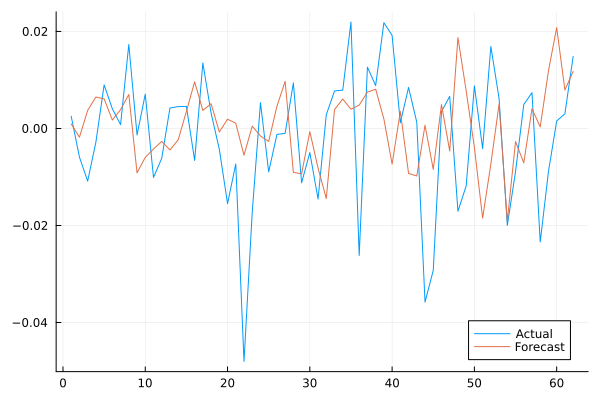

In [4]:
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using RollingFunctions

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
log_returns = diff(log.(aapl.close))
returns = (aapl.close[2:end] ./ aapl.close[1:end-1]) .- 1
println(returns)
train_idx = Int(round(length(returns) * 0.5))
valid_idx = Int(round(length(returns) * 0.75))
train, validate, test = returns[1:train_idx], returns[train_idx+1:valid_idx], returns[valid_idx:end]

function obj_reparam(params;data=validate, data_str="validate")
    params = round.(Int, params)
    function run_func(x)
        all_data = [train;x]
        multiplier = @suppress regress(all_data, params[1], params[2])
        return reshape(all_data[(end-params[1]+1):end], (1, params[1])) * multiplier
    end
    step_map = Dict()
    step_error = []
    expected_num = length(data) - params[1]

    forecast = running(run_func, data, length(data))
    for i in 1:params[2]
        # step_map[i] = fill(0.0, length(expected_num))
        # println(collect(Iterators.flatten(f[i] for f in forecast))[1:expected_num])
        step_map[i] = [fill(0.0, i-1);collect(Iterators.flatten(f[i] for f in forecast))][1:expected_num]
    end
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    error = predictions .- data[params[1]+1:end]
    for i in 1:params[2]
        e = step_map[i][i:end] .- data[params[1]+i:end]
        errors = errorResult(mean(abs.(e)), mean((e).^2))
        push!(step_error, errors)
    end

    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]    
    error = predictions .- data[params[1]+1:end]
    MAE = mean(abs.(error))
    MSE = mean(error.^2)
    p = plot(data[params[1]+1:end], label="Actual", title = "AAPL Forecast using Linear($(params[1]),$(params[2])) on $(data_str) set with reparameterisation")
    plot!(p, predictions[1:end-1], label="Forecast")
    for i in 1:params[2]
        plot!(p, step_map[i], label="Forecast step $(i)")
    end
    filename = "linear_plots/optimiser_plots_reparam/plot_$(params)_$(data_str).svg"
    savefig(p, filename)
    
    return mean([error.MAE for error in step_error])
end

problem = DSProblem(2, objective=obj_reparam, initial_point=[30.0,1.0], granularity=[1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4)
AddExtremeConstraint(problem, valcond)
Optimize!(problem)



# Add Reparameterisation Parameter

In [22]:
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using RollingFunctions

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
log_returns = diff(log.(aapl.close))
returns = (aapl.close[2:end] ./ aapl.close[1:end-1]) .- 1
println(returns)
train_idx = Int(round(length(returns) * 0.5))
valid_idx = Int(round(length(returns) * 0.75))
train, validate, test = returns[1:train_idx], returns[train_idx+1:valid_idx], returns[valid_idx:end]

function obj_reparam(params;data=validate, data_str="validate")
    params = round.(Int, params)
    function run_func(x)
        all_data = [train;x]
        multiplier = @suppress regress(all_data[(end-params[3]+1):end], params[1], params[2])
        return reshape(all_data[(end-params[1]+1):end], (1, params[1])) * multiplier
    end
    step_map = Dict()
    step_error = []
    expected_num = length(data) - params[1]

    forecast = running(run_func, data, length(data))
    for i in 1:params[2]
        # step_map[i] = fill(0.0, length(expected_num))
        # println(collect(Iterators.flatten(f[i] for f in forecast))[1:expected_num])
        step_map[i] = [fill(0.0, i-1);collect(Iterators.flatten(f[i] for f in forecast))][1:expected_num]
    end
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    error = predictions .- data[params[1]+1:end]
    for i in 1:params[2]
        e = step_map[i][i:end] .- data[params[1]+i:end]
        errors = errorResult(mean(abs.(e)), mean((e).^2))
        push!(step_error, errors)
    end

    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]    
    error = predictions .- data[params[1]+1:end]
    MAE = mean(abs.(error))
    MSE = mean(error.^2)
    p = plot(data[params[1]+1:end], label="Actual", title = "AAPL Forecast using Linear($(params[1]),$(params[2])) on $(data_str) set with reparameterisation")
    plot!(p, predictions[1:end-1], label="Forecast")
    for i in 1:params[2]
        plot!(p, step_map[i], label="Forecast step $(i)")
    end
    filename = "linear_plots/optimiser_plots_reparam_window/plot_$(params)_$(data_str).svg"
    savefig(p, filename)
    
    return mean([error.MAE for error in step_error])
end

problem = DSProblem(3, objective=obj_reparam, initial_point=[5.0,2.0,60], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

problem = DSProblem(3, objective=obj_reparam, initial_point=[1.0,1.0,5], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

problem = DSProblem(3, objective=obj_reparam, initial_point=[15.0,4.0,75], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

[0.010314231379827232, -0.010604653061194957, 0.036794101724815675, 0.004088865910060413, 0.004456410743407302, 0.02111229140844828, -0.0005993095195339082, 0.010119112567793076, 0.008756366745847899, -0.005369984658148752, 0.00044373608175840573, 0.01922074933545259, 0.02350043960188808, 0.010063058343160014, -0.00470075194473818, 0.014803370185255682, 0.013684258613779976, -0.020078070464177533, 0.009020932070858745, 0.007900751560697472, 0.03706260688917107, 0.024399897209064214, -0.01792883024246561, 0.019244699473851767, -0.017652737376545935, -0.006911552556695955, 0.0009279472007650558, 0.01880677902118011, -0.004224953717818392, 0.013903426404976438, -0.010429376798369527, -0.007546702305912589, -0.026679824600448265, 0.0028960664530148783, 0.0032905125399556034, -0.018005269695533066, 0.008247504598905886, -0.003447772533457294, -0.014246021649447993, 0.0041291453691869595, 0.035090089703815774, 0.01853938339660255, -0.014496494188358522, 0.00837723590066819, -0.01491462583974

# Using Price data instead of Returns data

In [24]:
using DirectSearch
using PrettyTables
using Suppressor
using Latexify
using RollingFunctions

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
aapl = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
log_returns = diff(log.(aapl.close))
# returns = (aapl.close[2:end] ./ aapl.close[1:end-1]) .- 1
train_idx = Int(round(length(returns) * 0.5))
valid_idx = Int(round(length(returns) * 0.75))
train, validate, test = returns[1:train_idx], returns[train_idx+1:valid_idx], returns[valid_idx:end]

function obj_reparam(params;data=validate, data_str="validate")
    params = round.(Int, params)
    function run_func(x)
        all_data = [train;x]
        multiplier = @suppress regress(all_data[(end-params[3]+1):end], params[1], params[2])
        return reshape(all_data[(end-params[1]+1):end], (1, params[1])) * multiplier
    end
    step_map = Dict()
    step_error = []
    expected_num = length(data) - params[1]

    forecast = running(run_func, data, length(data))
    minval = minimum(data)
    for i in 1:params[2]
        # step_map[i] = fill(0.0, length(expected_num))
        # println(collect(Iterators.flatten(f[i] for f in forecast))[1:expected_num])
        step_map[i] = [fill(minval, i-1);collect(Iterators.flatten(f[i] for f in forecast))][1:expected_num]
    end
    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]
    error = predictions .- data[params[1]+1:end]
    for i in 1:params[2]
        e = step_map[i][i:end] .- data[params[1]+i:end]
        errors = errorResult(mean(abs.(e)), mean((e).^2))
        push!(step_error, errors)
    end

    predictions = collect(Iterators.flatten([f for f in forecast[1:params[2]:end]]))[1:expected_num]    
    error = predictions .- data[params[1]+1:end]
    MAE = mean(abs.(error))
    MSE = mean(error.^2)
    p = plot(data[params[1]+1:end], label="Actual", title = "AAPL Forecast using Linear($(params[1]),$(params[2])) on $(data_str) set with reparameterisation")
    plot!(p, predictions[1:end-1], label="Forecast")
    for i in 1:params[2]
        plot!(p, step_map[i], label="Forecast step $(i)")
    end
    filename = "linear_plots/optimiser_plots_reparam_window_raw/plot_$(params)_$(data_str).svg"
    savefig(p, filename)
    
    return mean([error.MSE for error in step_error])
end

problem = DSProblem(3, objective=obj_reparam, initial_point=[5.0,2.0,60], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

problem = DSProblem(3, objective=obj_reparam, initial_point=[1.0,1.0,5], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

problem = DSProblem(3, objective=obj_reparam, initial_point=[15.0,4.0,75], granularity=[1,1,1])
valcond(x) = (0 < x[1] < (length(test) / 2)) &&  (0 < x[2] <= 4) && ((x[1] + x[2]) <= x[3] <= length(train))
AddExtremeConstraint(problem, valcond)
Optimize!(problem)

MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 1.0, 66.0]
Feasible Cost               6.476479930917717
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        48
Cache hits                  147
Optimization Status         Mesh Precision limit

Runtime                     8.956202030181885
Search Time                 1.2932000000000006e-5
Poll Time                   0.007974289999999998
Blackbox Evaluation Time    6.6681278230000025
MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 1.0, 43.0]
Feasible Cost               6.512576827364914
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  60
Function Evaluations        38
Cache hits                  150
Optimization Status         Mesh Precision limit

Runtime                     4.13641095161438
Search Time  

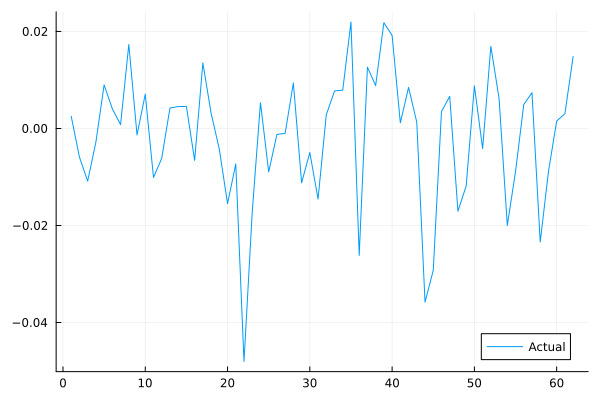

In [28]:
tmp = validate
tmp_ret = tmp[2:end] ./ tmp[1:end-1] .- 1
plot(tmp_ret, label="Actual")